In [1]:
import numpy as np
#from jax import grad, jacrev, jacfwd, jit, vmap
#import jax.numpy as jnp
#import jax.scipy as jscp

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import seaborn as sns
import scipy as scp

#import jax
#jax.config.update("jax_platform_name", "cpu")

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})


np.random.seed(32)

In [2]:
Phi_g = lambda v: scp.stats.norm.cdf(v, loc=0, scale=1)
phi_g = lambda v: scp.stats.norm.pdf(v, loc=0, scale=1)

In [3]:
def psi_g(alpha, sigma):
    return Phi_g((1- alpha)/sigma) * (1 - alpha) + phi_g((1- alpha)/sigma) * sigma

In [4]:
Phi_m = lambda v: (1 + v/np.sqrt(1 + v**2))/2
phi_m = lambda v: 1/(2 * np.sqrt(1 + v**2))

The two terms which make up the smooth hinge loss are,
\begin{align*}
    \Phi_m(v) = (1 + v/\sqrt{(1 + v^2)})/2 \\
    \phi_m(v) = 1/(2 \cdot \sqrt{(1 + v^2)}).
\end{align*}

Where the final form is,
\begin{align*}
    \psi_m(v) = \Phi_m(v/\sigma) \cdot v + \phi_m(v/\sigma) \cdot \sigma,
\end{align*}
for $v = 1 - \alpha$ and we use $\alpha = yXw$ for the SVM.

Now, the derivative for the individual terms wrt $v$ is,

\begin{align*}
    \frac{\partial \Phi_m(v)}{\partial v} = \frac{1}{2(v^2+1)^{\frac{3}{2}}} \\
    \frac{\partial \phi_m(v)}{\partial v} = -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}}
\end{align*}

$(1 + (v/\sigma)/(\sqrt{1+(v/\sigma)^2}))*v/2 + 1/(2\sqrt{(1+(v/\sigma)^2})) * \sigma$
$(1 + (1-\alpha/\sigma)/(\sqrt{1+(1-\alpha/\sigma)^2}))*1-\alpha/2 + 1/(2\sqrt{(1+(1-\alpha/\sigma)^2})) * \sigma$
$(1 + (1-yXw/\sigma)/(\sqrt{1+(1-yXw/\sigma)^2}))*1-yXw/2 + 1/(2\sqrt{(1+(1-yXw/\sigma)^2})) * \sigma$

So, the derivative of the smooth hinge loss for $v = 1 - \alpha$ is,
\begin{align*}
    \frac{\partial \psi_m(v)}{\partial v} &= \left(\frac{\partial \Phi_m(v)}{\partial v} \cdot v + \Phi_m(v) \cdot \frac{\partial v}{\partial \alpha} \right) + \frac{\partial \phi_m(v)}{\partial v} \cdot \sigma \\
    &= \frac{1}{2(v^2+1)^{\frac{3}{2}}} \cdot v - \frac{1}{2}\left(1 + \frac{v}{\sqrt{(1 + v^2)}}\right) -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}} \cdot \sigma \\
    &= \frac{v(1 - \sigma)}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2} - \frac{v}{2(1 + v^2)^{\frac{1}{2}}} \\
    &= \frac{v(1 - \sigma - (1 + v^2))}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2}.
\end{align*}

In [5]:
def nabla_psi(alpha, sigma):
    v = 1 - alpha
    return (v * (1 - sigma + (1 + v**2)))/(2 * np.sqrt((v**2 + 1))**3) - 1/2

In [6]:
def psi_m(alpha, sigma):
    return Phi_m((1 - alpha)/sigma) * (1 - alpha) + phi_m((1 - alpha)/sigma) * sigma

In [7]:
def L(w, X, y, sigma, lbd=0.3):
    return 1/2 * lbd *  np.linalg.norm(w, ord=2)**2 + np.mean(psi_m(y * (X @ w), sigma))

In [8]:
def L_alt(w, X, y, sigma, lbd=0.3):
    return np.mean(psi_m(y * (X @ w), sigma))

In [9]:
#X, y = make_blobs(n_samples=200, n_features=2, centers=[[-1,-1], [1,1]], cluster_std=1.5)
#X, y = make_blobs(n_samples=150, n_features=2, centers=[[5,0], [7,0]])
#X, y = make_blobs(n_samples=250, n_features=2, centers=[[0,-1], [0,1]])
X, y = make_moons(n_samples=100, noise=0.2, random_state=13)
y[np.where(y == 0)] = -1

In [10]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [11]:
clf = SVC(kernel='linear').fit(X, y)
print(clf.coef_)
print(clf.intercept_)

[[ 0.76453359 -1.19279601]]
[-0.02620717]


In [12]:
#X = np.c_[X, np.ones(X.shape[0])]

In [13]:
print(X.shape)
print(y.shape)

n = X.shape[0]
p = X.shape[1]

(100, 2)
(100,)


In [14]:
def nabla_psi_X(X, y, w, sigma):
    #numerator = y @ X * (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    numerator = (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    denom = 2 * sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3
    return -numerator/denom

In [15]:
def nabla_fgd(X, y, w, sigma, lbd):
    return -(lbd * w - 1/n * y @ X * Phi_m((1 - y @ X * w)/sigma))

def nabla_fgd_single(X, y, w, sigma, lbd):
    return -(lbd * w - 1/n * y * X * Phi_m((1 - y * X * w)/sigma))

In [16]:
def hess_fgd(X, y, w, sigma, lbd):
    d = phi_m((1 - y @ X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return -hess

In [17]:
def hess_fgd_single(X, y, w, sigma, lbd):
    d = phi_m((1 - y * X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return -hess

In [18]:
# gradient testing
w_og = np.zeros(p)
n_iter = 400
eta = 0.3
sigma = 0.01
lbd = 0.85

alpha_t = 0.75/n

w_true_og = np.zeros((n, p))
w_cv_og = np.zeros((n, p))

for t in range(n_iter):
    f_grad = nabla_fgd(X, y, w_og, sigma, lbd)
    f_hess = hess_fgd(X, y, w_og, sigma, lbd)
    
    hess_per_sample = np.zeros((n, p, p))
    for i in range(n):
        hess_per_sample[i] = hess_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    grad_per_sample = np.zeros((n, p))
    for i in range(n):
        grad_per_sample[i] = nabla_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    hess_minus_i = f_hess - hess_per_sample
    grad_minus_i = f_grad - grad_per_sample
    
    #print(f_hess)
    w_cv_og = w_cv_og - alpha_t * grad_minus_i - alpha_t * np.vectorize(np.matmul, signature='(p, p),(p)->(p)')(hess_minus_i, (w_cv_og - w_og))
    w_cv_og /= np.asarray([np.linalg.norm(w_cv_og, axis=1)] * p).T
    
    for i in range(n):
        X_temp = np.delete(X, (i), axis=0)
        y_temp = np.delete(y, (i), axis=0)
        w_true_og[i] = w_true_og[i] - eta * nabla_fgd(X_temp, y_temp, w_true_og[i], sigma, lbd)
        #w_true_og[i] = w_true_og[i] - eta * (lbd * w_true_og[i] - y @ X * Phi_m((1 - y_temp @ X_temp * w_true_og[i])/sigma))
        
    #w_true_og /= np.linalg.norm(w_true_og, axis=0)
    w_true_og /= np.asarray([np.linalg.norm(w_true_og, axis=1)] * p).T
    w_og = w_og - eta * f_grad
    w_og /= np.linalg.norm(w_og)
    #w_og = w_og - eta * (lbd * w_og - np.mean(Phi_m((1 - y @ X * w_og)/sigma)))
    print(f"{w_og} | IACV: {np.mean(np.linalg.norm(w_true_og - w_cv_og, 2, axis=1))} | baseline: {np.mean(np.linalg.norm(w_true_og - w_og, 2, axis=1))}")


#w_og /= np.linalg.norm(w_og)
print(np.mean(w_true_og, axis=0))
print(np.mean(w_cv_og, axis=0))
#w_og = w_og/np.linalg.norm(w_og)
#print(w_og/np.linalg.norm(w_og))

[-0.64964328  0.76023918] | IACV: 1.7841893265943817e-16 | baseline: 0.009007252566670752
[-0.64964328  0.76023918] | IACV: 8.485266418694958e-07 | baseline: 0.009007252665014447
[-0.64964328  0.76023918] | IACV: 1.6921260193611697e-06 | baseline: 0.00900725274836011
[-0.64964328  0.76023918] | IACV: 2.5308341221081304e-06 | baseline: 0.009007252818995148
[-0.64964328  0.76023918] | IACV: 3.3646855590621455e-06 | baseline: 0.009007252878858073
[-0.64964328  0.76023918] | IACV: 4.193713746150995e-06 | baseline: 0.009007252929591748
[-0.64964327  0.76023918] | IACV: 5.017952772362784e-06 | baseline: 0.009007252972588477
[-0.64964327  0.76023918] | IACV: 5.837435480778533e-06 | baseline: 0.00900725300902821
[-0.64964327  0.76023918] | IACV: 6.6521902795205335e-06 | baseline: 0.009007253039910946
[-0.64964327  0.76023918] | IACV: 7.4622492454625614e-06 | baseline: 0.00900725306608416
[-0.64964327  0.76023918] | IACV: 8.267643181262626e-06 | baseline: 0.009007253088266045
[-0.64964327  0.76

In [19]:
print(np.linalg.norm(w_true_og - w_cv_og, 2))
print(np.linalg.norm(w_true_og - w_og, 2))

0.011276106978489814
0.10888042713905298


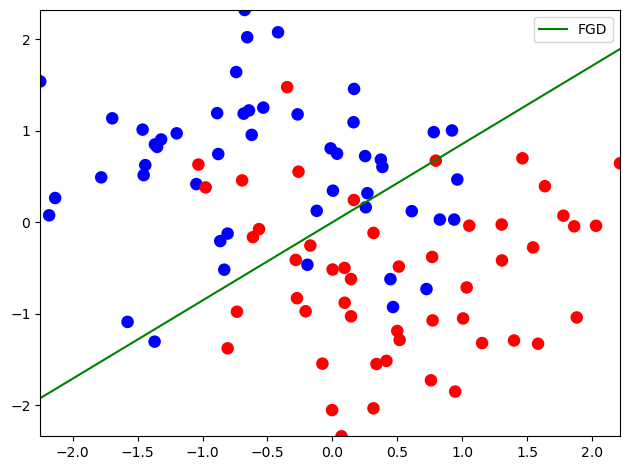

In [20]:
def plot_line(ax, theta, label, color, **kwargs):
    #theta[:2] /= np.linalg.norm(theta[:2], 2) ## probably get rid of this
    a = -theta[0] / theta[1]
    #yy = a * xx - theta[2] / theta[1]
    yy = a * xx
    ax.plot(xx, yy, label=label, c=color, **kwargs)

fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#mins = np.argsort(np.sum(w_cv, axis=1), axis=0)[:50]
#print(np.sum(w_cv, axis=1)[mins])
#ax.scatter(*X[mins].T, c="black", linewidths=10)

#plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "plum")
#plot_line(ax, w, f"SmoothHinge ($\sigma$={sigma})", "purple")
plot_line(ax, w_og, f"FGD", "green")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_comp.pgf', bbox_inches='tight', pad_inches=0)

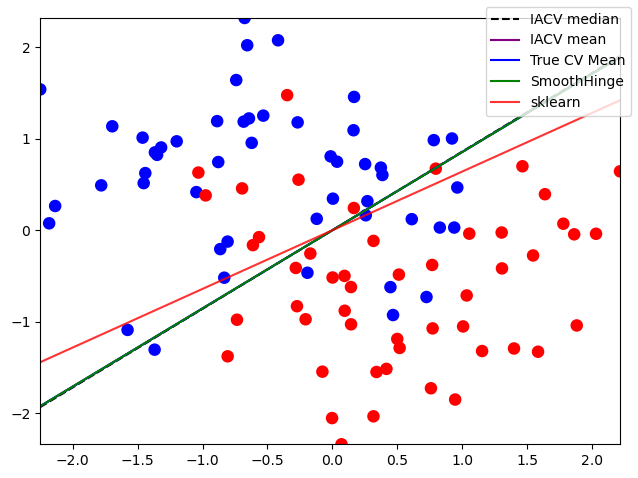

In [21]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#median_w = np.median(np.abs(w_cv_og), axis=0)
median_w = np.median(w_cv_og, axis=0)
#median_w /= np.linalg.norm(median_w, 2)
plot_line(ax, median_w, "IACV median", "black", linestyle='--')

#mean_w = np.mean(np.abs(w_cv_og), axis=0)
mean_w = np.mean(w_cv_og, axis=0)
#mean_w /= np.linalg.norm(mean_w, 2)
plot_line(ax, mean_w, "IACV mean", "purple")

#w_true_mean = np.mean(np.abs(w_true_og), axis=0)
w_true_mean = np.mean(w_true_og, axis=0)
w_true_mean /= np.linalg.norm(w_true_mean, 2)

plot_line(ax, w_true_mean, f"True CV Mean", "blue")
plot_line(ax, w_og, f"SmoothHinge", "green")

plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "red", alpha=0.8)

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
fig.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_stats.pgf', bbox_inches='tight', pad_inches=0)

[-0.64145336  0.76716159]
[-0.65722386  0.75369541]


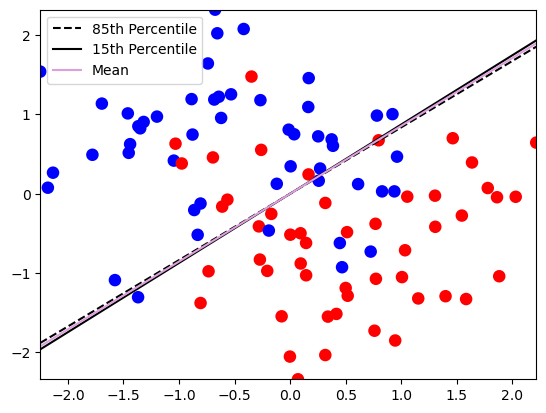

In [22]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

t_percentile = 85
l_percentile = 100 - t_percentile
top_w = np.asarray([np.percentile(w_cv_og[:, i], t_percentile) for i in range(w_cv_og.shape[1])])
#top_w = np.abs(top_w)
#top_w /= np.linalg.norm(top_w, 2)
print(top_w)
plot_line(ax, top_w, f"{t_percentile}th Percentile", "black", linestyle='--')

bottom_w = np.asarray([np.percentile(w_cv_og[:, i], l_percentile) for i in range(w_cv_og.shape[1])])
#bottom_w = np.abs(bottom_w)
#bottom_w /= np.linalg.norm(bottom_w, 2)
print(bottom_w)
plot_line(ax, bottom_w, f"{l_percentile}th Percentile", "black")

#mid_p = (np.abs(bottom_w) + np.abs(top_w))/2
#mid_p = (bottom_w + top_w)/2
#print(mid_p)
#mid_p /= np.linalg.norm(mid_p, 2)
#plot_line(ax, median_w, "Median", "plum")
plot_line(ax, mean_w, "Mean", "plum")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()
plt.show()

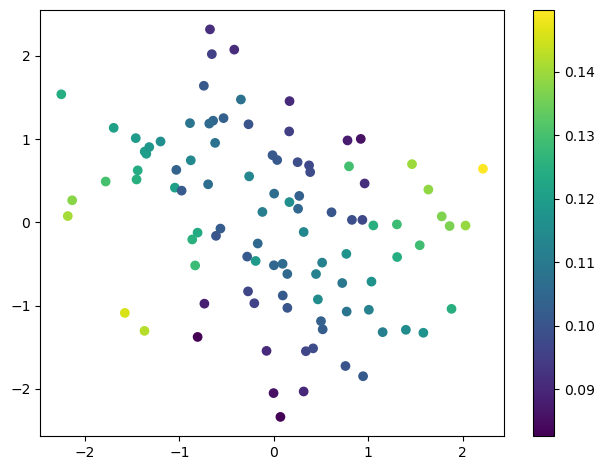

In [23]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_cv_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)

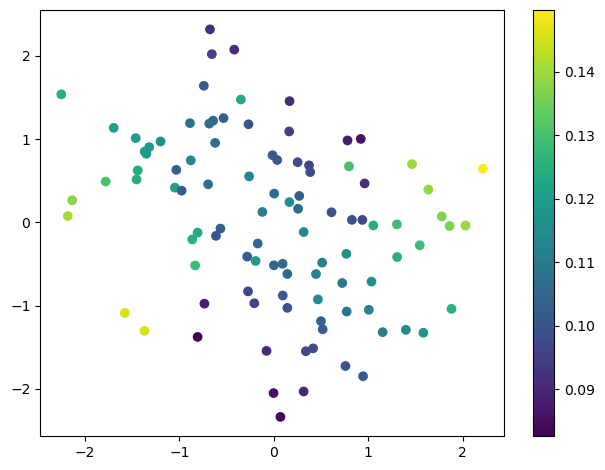

In [24]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_true_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)